In [1]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# For image manipulation
import cv2
import imutils

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras import layers
from keras import models

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
import os
import shutil
import random

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

## Data
Pituitary, no tumor, meningioma, and glioma images (7023 total, ~80/20 train test split): https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Other tumor images (1171 T1C+ images that I will use): https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c

In [2]:
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

# Create a new directory named "other" in the train directory
new_train_dir = os.path.join(train_dir, 'other')
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)

# Create a new directory named "other" in the test directory
new_test_dir = os.path.join(test_dir, 'other')
if not os.path.exists(new_test_dir):
    os.makedirs(new_test_dir)
    
# # delete files in new_train_dir
# for file_name in os.listdir(new_train_dir):
#     file_path = os.path.join(new_train_dir, file_name)
#     try:
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#     except Exception as e:
#         print(f"Error deleting file: {file_path}")
#         print(e)

# # delete files in new_test_dir
# for file_name in os.listdir(new_test_dir):
#     file_path = os.path.join(new_test_dir, file_name)
#     try:
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#     except Exception as e:
#         print(f"Error deleting file: {file_path}")
#         print(e)

In [3]:
supplement_labels = ['Astrocitoma T1C+', 'Carcinoma T1C+', 'Ependimoma T1C+', 'Ganglioglioma T1C+',
                'Germinoma T1C+', 'Granuloma T1C+', 'Meduloblastoma T1C+', 'Neurocitoma T1C+',
                'Oligodendroglioma T1C+', 'Papiloma T1C+', 'Schwannoma T1C+', 'Tuberculoma T1C+']

supplement_path = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/supplement/'

# Copy 80% of images to the new "other" directory in train_dir and 20% to the new "other" directory in test_dir
for label in supplement_labels:
    folder_path = os.path.join(supplement_path, label)
    files = os.listdir(folder_path)
    random.shuffle(files)
    num_files = len(files)
    num_train_files = int(num_files * 0.8)
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]
    
    for filename in train_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_train_dir, filename)
            shutil.move(src_path, dst_path)
                
    for filename in test_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_test_dir, filename)
            shutil.move(src_path, dst_path)

In [4]:
labels = ['pituitary', 'notumor', 'meningioma', 'glioma', 'other']

X_train = []
y_train = []

for label in labels:
    for image in os.listdir(train_dir+label):
        X_train.append(train_dir+label+'/'+image)
        y_train.append(label)

X_train, y_train = shuffle(X_train, y_train)

In [5]:
X_test = []
y_test = []

for label in labels:
    for image in os.listdir(test_dir+label):
        X_test.append(test_dir+label+'/'+image)
        y_test.append(label)

X_test, y_test = shuffle(X_test, y_test)

In [6]:
tumor_train_df = pd.concat([pd.Series(X_train, name = 'paths'), 
                            pd.Series(y_train, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0476.jpg,meningioma
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/2022-06-13 12_52_08-Choroid plexus papilloma _ Radiology Case _ Radiopaedia.org.jpg,other
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/IMG-0010-00010_big_gallery.jpeg,other
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0897.jpg,meningioma
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0617.jpg,meningioma
...,...,...
6633,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0942.jpg,notumor
6634,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0238.jpg,meningioma
6635,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_1286.jpg,pituitary
6636,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0252.jpg,notumor


In [7]:
tumor_test_df = pd.concat([pd.Series(X_test, name = 'images'), 
                            pd.Series(y_test, name = 'label')], 
                            axis = 1)
tumor_test_df

,images,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0177.jpg,glioma
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0145.jpg,glioma
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/cf07b5c5c9ac49c851393f3071fc906c7f0ff6792a1d0c2f4805f794dafc8f28_big_gallery.jpeg,other
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0130.jpg,notumor
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/122._big_gallery.jpeg,other
...,...,...
1552,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0130.jpg,glioma
1553,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/9d77327188f206a6f3ee76cd0904e9680906169c424cc46e4474c61dec5187c1_big_gallery.jpeg,other
1554,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/meningioma/Te-me_0091.jpg,meningioma
1555,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0166.jpg,glioma


## Exploratory Data Analysis

In [8]:
tumor_train_df.shape

(6638, 2)

In [9]:
tumor_train_df['label'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
other          926
Name: label, dtype: int64

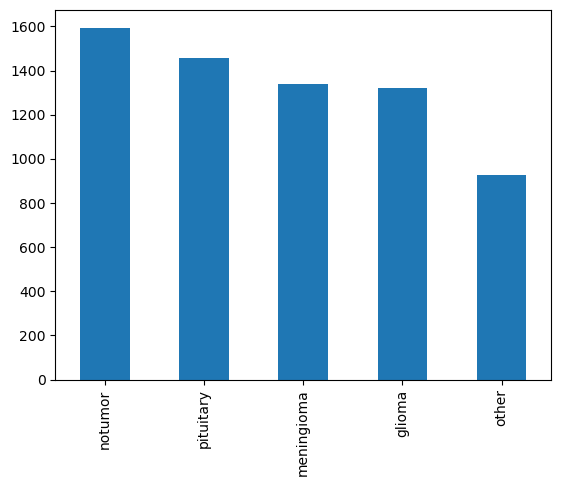

In [10]:
tumor_train_df['label'].value_counts().plot(kind = 'bar');

In [11]:
tumor_test_df['label'].value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
other         246
Name: label, dtype: int64

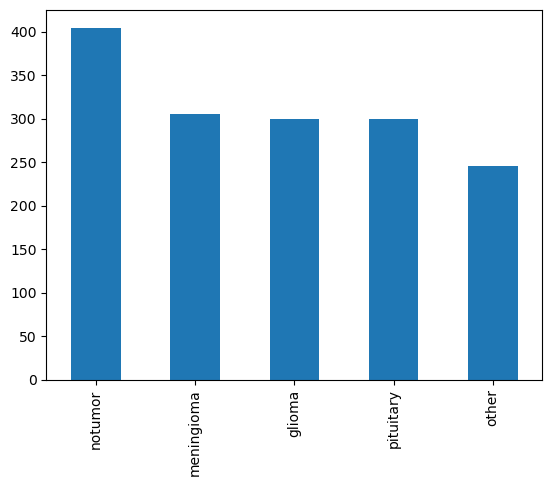

In [12]:
tumor_test_df['label'].value_counts().plot(kind = 'bar');

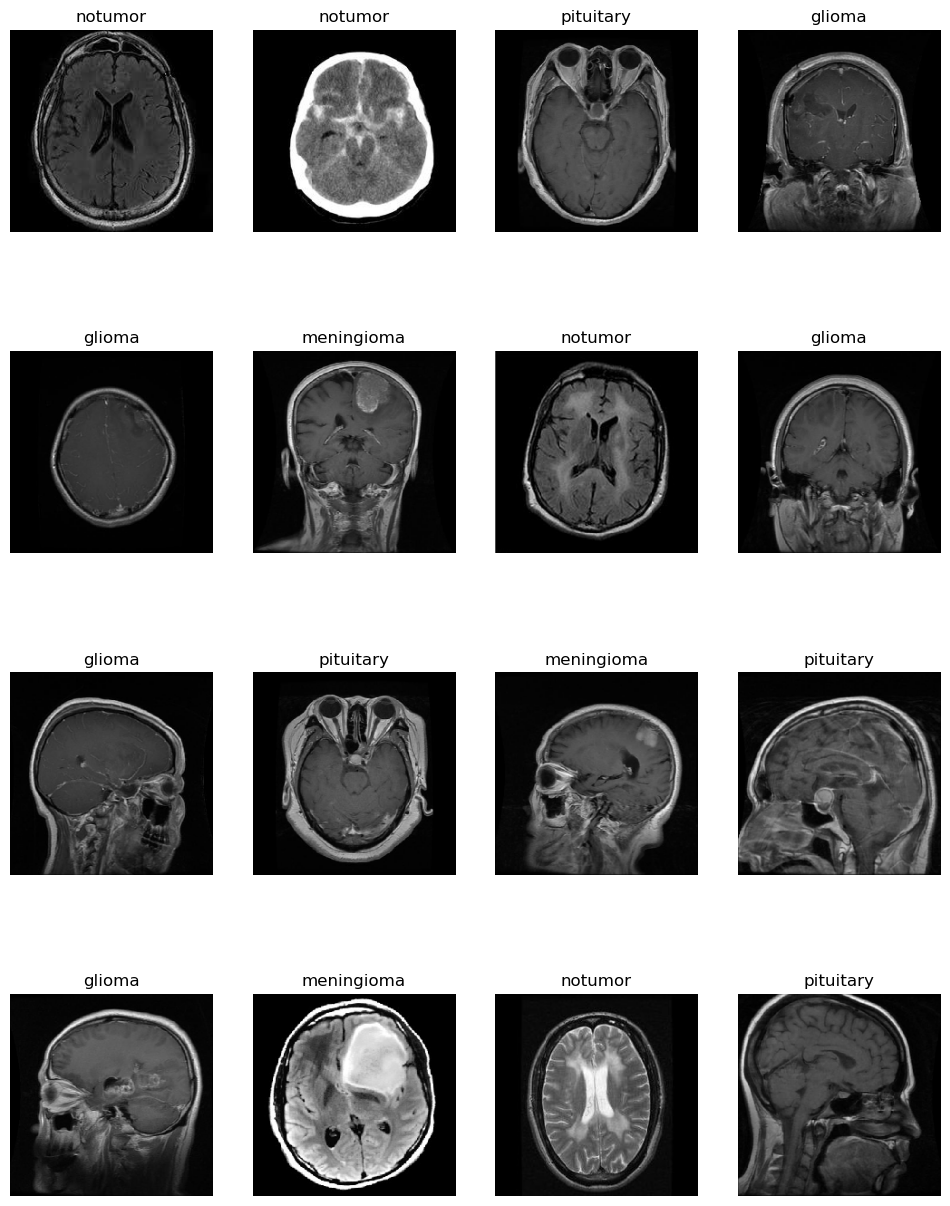

In [13]:
# with gratitude to MD Mushfirat Mohaimin for this code
# https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96

IMAGE_SIZE = (224, 224)

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMAGE_SIZE)
        images.append(image)
    return np.array(images, dtype=object)

images = open_images(X_train[50:67])
labels = y_train[50:67]
fig = plt.figure(figsize=(12, 16))
for x in range(1, 17):
    fig.add_subplot(4, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Baseline Model

In [14]:
train_datagen_baseline = ImageDataGenerator(rescale=1./255)
test_datagen_baseline = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator_baseline = train_datagen_baseline.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

test_generator_baseline = test_datagen_baseline.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 6636 images belonging to 5 classes.
Found 1556 images belonging to 5 classes.


In [15]:
reg = l2(3e-3)
cce = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
callback = EarlyStopping(monitor='loss', patience=2)

model = Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
base_model = model.fit(train_generator_baseline,
                       verbose = 1,
                       validation_data = test_generator_baseline, 
                       epochs=30,
                       callbacks = [callback])

Metal device set to: Apple M1 Pro
Epoch 1/30


2023-04-06 14:48:55.449936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 14:48:55.450062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-06 14:48:55.614888: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  3/208 [..............................] - ETA: 5s - loss: 6.8615 - accuracy: 0.2396 

2023-04-06 14:48:55.770981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.5826

2023-04-06 14:49:04.763911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 11s 52ms/step - loss: 1.3848 - accuracy: 0.5826 - val_loss: 0.8937 - val_accuracy: 0.6947
Epoch 2/30
208/208 [==============================] - 10s 47ms/step - loss: 0.6985 - accuracy: 0.7599 - val_loss: 0.9813 - val_accuracy: 0.6382
Epoch 3/30
208/208 [==============================] - 10s 47ms/step - loss: 0.5635 - accuracy: 0.8085 - val_loss: 0.6320 - val_accuracy: 0.7886
Epoch 4/30
208/208 [==============================] - 10s 49ms/step - loss: 0.4893 - accuracy: 0.8341 - val_loss: 0.7439 - val_accuracy: 0.7172
Epoch 5/30
208/208 [==============================] - 10s 48ms/step - loss: 0.4148 - accuracy: 0.8511 - val_loss: 0.6746 - val_accuracy: 0.7821
Epoch 6/30
208/208 [==============================] - 10s 48ms/step - loss: 0.4563 - accuracy: 0.8376 - val_loss: 0.6116 - val_accuracy: 0.8066
Epoch 7/30
208/208 [==============================] - 10s 47ms/step - loss: 0.3370 - accuracy: 0.8817 - val_loss: 0.5267 - val_accuracy: 0.8233
Epo

In [16]:
# # with gratitude to Ruslan Klymentiev for this function and the two cells below
# # https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16
# # and Adrian Rosebrock from pyimagesearch for the underlying concept
# # https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
# def crop_imgs(set_name, add_pixels_value=0):
#     """
#     Finds the extreme points on the image and crops them
#     """
#     set_new = []
#     for img in set_name:
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         gray = cv2.GaussianBlur(gray, (5, 5), 0)

#         # threshold the image, then perform a series of erosions +
#         # dilations to remove any small regions of noise
#         thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#         thresh = cv2.erode(thresh, None, iterations=2)
#         thresh = cv2.dilate(thresh, None, iterations=2)

#         # find contours in thresholded image, then grab the largest one
#         cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         c = max(cnts, key=cv2.contourArea)

#         # find the extreme points
#         extLeft = tuple(c[c[:, :, 0].argmin()][0])
#         extRight = tuple(c[c[:, :, 0].argmax()][0])
#         extTop = tuple(c[c[:, :, 1].argmin()][0])
#         extBot = tuple(c[c[:, :, 1].argmax()][0])

#         ADD_PIXELS = add_pixels_value
#         new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         set_new.append(new_img)

#     return np.array(set_new)

In [17]:
# img = cv2.imread(train_paths[58])
# img = cv2.resize(
#             img,
#             dsize=IMAGE_SIZE,
#             interpolation=cv2.INTER_CUBIC
#         )
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)

# # threshold the image, then perform a series of erosions +
# # dilations to remove any small regions of noise
# thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
# thresh = cv2.erode(thresh, None, iterations=2)
# thresh = cv2.dilate(thresh, None, iterations=2)

# # find contours in thresholded image, then grab the largest one
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# c = max(cnts, key=cv2.contourArea)

# # find the extreme points
# extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot = tuple(c[c[:, :, 1].argmax()][0])

# # add contour on the image
# img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# # add extreme points
# img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
# img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
# img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
# img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# # crop
# new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

In [18]:
# fig, axes = plt.subplots(ncols = 4, figsize=(15,6))
# axes[0].axis('off')
# axes[1].axis('off')
# axes[2].axis('off')
# axes[3].axis('off')

# axes[0].imshow(img)
# axes[0].set_title('Step 1. Get the original image')
# axes[1].imshow(img_cnt)
# axes[1].set_title('Step 2. Find the biggest contour')
# axes[2].imshow(img_pnt)
# axes[2].set_title('Step 3. Find the extreme points')
# axes[3].imshow(new_img)
# axes[3].set_title('Step 4. Crop the image')

# plt.tight_layout()
# plt.show()